# Transfer Learning - Flowers

Este ejemplo fue extraido desde un sitio educacional de Google. Para ejecutar este ejemplo, se puede hacer con un backend GPU, pues no es un proceso muy demandante.

Este sitio que explica el ejemplo original ya no se encuentra disponible, para que se pueda usar, cambie cargas a manual, se debe instalar esto para pip: 


pip install tensorflow-datasets


o en el caso de usar coda: 

conda install -c conda-forge tensorflow-datasets

## Imports

In [73]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.20.0-rc0


In [74]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

## Configuración

In [75]:
# Parámetros de los archivos TFRecord originales (no utilizados directamente en la versión local)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']  # do not change, maps to the labels in the data (folder names)

Number of accelerators:  1
1e-05 5.9807360000000024e-05


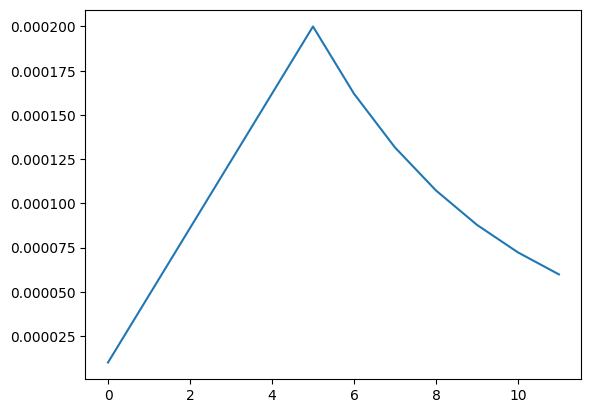

In [76]:
# Configuración de estrategia de distribución (simplificada para evitar conflictos)


import tensorflow as tf


# Usamos siempre la estrategia por defecto (CPU / 1 GPU)


strategy = tf.distribute.get_strategy()


print("Number of accelerators: ", strategy.num_replicas_in_sync)


EPOCHS = 12
IMAGE_SIZE = [331, 331]


FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec',
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"


# Parámetros de LR (se mantienen, pero sin usar TPU/GPU avanzados)
BATCH_SIZE = 16
VALIDATION_BATCH_SIZE = 16
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.0002
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8


def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)


lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)


rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [77]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Lectura de imagenes y etiquetas desde TFRecords

In [78]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }

    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    
    return image, class_label


def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

  return dataset
  

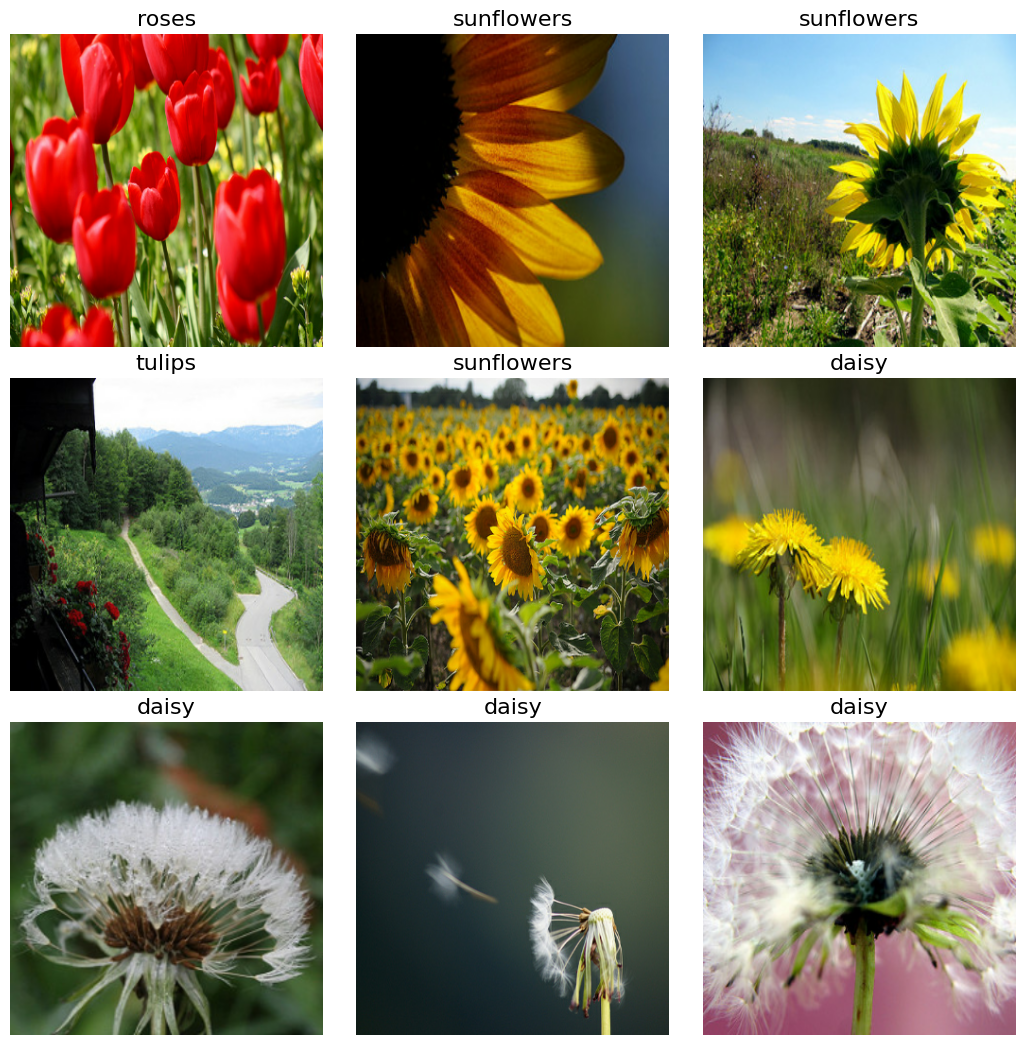

In [79]:
import tensorflow_datasets as tfds

# 1. Descargamos el dataset directamente a tu Mac/Colab
# Esto evitará cualquier error de "Permission Denied" de Google Cloud
dataset_name = "tf_flowers"
(ds_train), ds_info = tfds.load(
    dataset_name,
    split='train',
    with_info=True,
    as_supervised=True,  # Para que devuelva (imagen, etiqueta)
)

# 2. Re-adaptamos el dataset para que se parezca al original del curso
def preprocess_image(image, label):
    image = tf.image.resize(image, [331, 331])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = ds_train.map(preprocess_image)

# 3. Mostramos las imágenes usando tu función original
# Nota: display_9_images_from_dataset internamente llama a dataset_to_numpy_util
display_9_images_from_dataset(dataset)

## Training y Validation datasets

In [80]:
# --- TRAINING Y VALIDATION DATASETS (USANDO TF_FLOWERS LOCAL) ---

# En lugar de leer TFRecords desde Google Cloud Storage (que requiere permisos),
# reutilizamos los datasets locales descargados con tensorflow_datasets en la celda anterior.

# 1. Usamos los datasets ya preprocesados
training_dataset = ds_train.map(preprocess_image).cache().shuffle(1000).batch(16).repeat().prefetch(AUTOTUNE)
validation_dataset = dataset.batch(16).cache().prefetch(AUTOTUNE)

# 2. Calculamos el número aproximado de ejemplos para train/valid
num_total = ds_info.splits['train'].num_examples
num_train = int(num_total * 0.8)
num_valid = num_total - num_train

# 3. Definimos los pasos por época en función del batch size (16)
BATCH_SIZE_LOCAL = 16
steps_per_epoch = num_train // BATCH_SIZE_LOCAL
validation_steps = num_valid // BATCH_SIZE_LOCAL

print(f"Imágenes totales: {num_total}")
print(f"Imágenes de entrenamiento: {num_train}")
print(f"Imágenes de validación: {num_valid}")
print("Se usarán {} batches por epoch y {} batches para validación.".format(steps_per_epoch, validation_steps))

Imágenes totales: 3670
Imágenes de entrenamiento: 2936
Imágenes de validación: 734
Se usarán 183 batches por epoch y 45 batches para validación.


## Modelo Neuronal [IMPLEMENTAR]
1. Start with a dummy single-layer model using one dense layer:
 * Use  a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model. The constructor takes a list of layers.
 * First, [`Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the pixel values of the the input image to a 1D vector so that a dense layer can consume it:<br/>
 `tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3])  # the first layer must also specify input shape`
 * Add a single [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers):<br/>
  `tf.keras.layers.Dense(5, activation='softmax')`
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need `'sparse_categorical_crossentropy'` loss, `'accuracy'` in metrics and you can use the `'adam'` optimizer.

 **==>Train this model: not very good... but all the plumbing is in place.**

1. Instead of trying to figure out a better architecture, we will adapt a pretrained model to our data. Please remove all your layers to restart from scratch.
 * Instantiate a pre-trained model from `tf.keras.applications.*`
 You do not need its final softmax layer (`include_top=False`) because you will be adding your own. This code is already written in the cell below.<br/>
 * Use `pretrained_model` as your first "layer" in your Sequential model.
 * Follow with  [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) to turn the data from the pretrained model into a flat 1D vector.
 * Add your [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers).

 **==>Train the model: you should be able to reach above 75% accuracy by training for 10 epochs**

1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last one which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.

This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

In [81]:
# --- BLOQUE ÚNICO DE CARGA Y ENTRENAMIENTO (REEMPLAZA TU CELDA DE ERROR CON ESTO) ---

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# 1. CARGA LOCAL (Descarga directa, sin problemas de permisos de Google Cloud)
print("Descargando dataset de flores... (aprox. 200MB)")
dataset_name = "tf_flowers"
(ds_train, ds_valid), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'], # 80% entrenamiento, 20% validación
    with_info=True,
    as_supervised=True
)

# 2. PROCESAMIENTO
IMAGE_SIZE_LOCAL = [331, 331]
BATCH_SIZE_LOCAL = 16

def preprocess_local(image, label):
    image = tf.image.resize(image, IMAGE_SIZE_LOCAL)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Configuración del pipeline de datos
train_ds = ds_train.map(preprocess_local).cache().shuffle(1000).batch(BATCH_SIZE_LOCAL).repeat().prefetch(tf.data.AUTOTUNE)
valid_ds = ds_valid.map(preprocess_local).batch(BATCH_SIZE_LOCAL).cache().prefetch(tf.data.AUTOTUNE)

# 3. DEFINICIÓN DEL MODELO SIMPLE
print("Construyendo el modelo...")
simple_model = Sequential([
    Flatten(input_shape=(331, 331, 3)),
    Dense(5, activation='softmax')
])

simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. CÁLCULO DE PASOS
steps_per_epoch = (ds_info.splits['train'].num_examples * 0.8) // BATCH_SIZE_LOCAL
validation_steps = (ds_info.splits['train'].num_examples * 0.2) // BATCH_SIZE_LOCAL

# 5. ENTRENAMIENTO
print(f"Iniciando entrenamiento local (Epochs: 5)...")
history_simple = simple_model.fit(
    train_ds,
    validation_data=valid_ds,
    steps_per_epoch=int(steps_per_epoch),
    validation_steps=int(validation_steps),
    epochs=5
)

Descargando dataset de flores... (aprox. 200MB)
Construyendo el modelo...
Iniciando entrenamiento local (Epochs: 5)...
Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3391 - loss: 33.7476 - val_accuracy: 0.3472 - val_loss: 23.1431
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3986 - loss: 23.1422 - val_accuracy: 0.3597 - val_loss: 21.8163
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4736 - loss: 15.4152 - val_accuracy: 0.3611 - val_loss: 22.1033
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4729 - loss: 17.8778 - val_accuracy: 0.3250 - val_loss: 40.6484
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4932 - loss: 18.7452 - val_accuracy: 0.3931 - val_loss: 20.3265


In [82]:
# modelos pre-entrenados
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False


C:\Users\adria\AppData\Local\Temp\ipykernel_54212\3644029015.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)


In [83]:
# implementar arquitectura
# [COMPLETADO]


with strategy.scope():
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [84]:
# compilacion del modelo
# [COMPLETADO]


from tensorflow.keras.optimizers import Adam


with strategy.scope():
    model.compile(
        optimizer=Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

In [85]:
# sumario del modelo
# [COMPLETADO]

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 11, 11, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training

In [86]:
# Entrenamiento
history = model.fit(
    training_dataset,
    steps_per_epoch=int(steps_per_epoch),  # asegurar entero
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/12
109/183 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.6763 - loss: 0.8588

KeyboardInterrupt: 

In [ ]:
# Evaluacion del modelo
print(model.evaluate(validation_dataset))

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predicciones

In [ ]:
# Predicciones aleatorias sobre el conjunto de validación local
# Ejecuta varias veces para ver distintos ejemplos

for images, labels in validation_dataset.take(1):
    flowers = images.numpy()
    labels_np = labels.numpy()

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels_np)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
